# Load the Data and Plot

<ErrorbarContainer object of 3 artists>

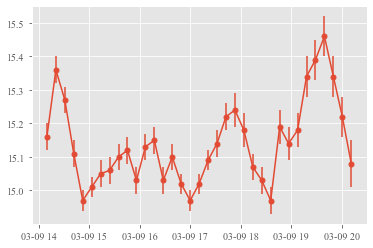

In [3]:
import pandas as pd

header_names = ["Julian_Date", "Magnitude", "Mag_Error"]

df = pd.read_csv("../data/OpenProject/lc_20180309_14160146_Samcoulson.dat",
                 header=None, 
                 sep="\s+", 
                 names=header_names,
                 encoding='utf-8')
timeSTR = pd.to_datetime(df["Julian_Date"], origin='julian', unit='D')
df.set_index(timeSTR, inplace=True)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager


plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

fig, ax = plt.subplots()
ax.errorbar(df.index, df['Magnitude'], 
            yerr=df['Mag_Error'], 
            marker='o', 
            markersize=5)

# Construct the matrix $A$

In [4]:
pi = np.pi
time = np.arange(len(df.index)) / (len(df.index) - 1)
m = np.array(df['Magnitude'])

A = np.vander(time, 5, increasing=True)

for i in range(4):
    sin = np.sin(2 * pi * (i + 1) * time)
    A = np.concatenate((A, sin.reshape(-1, 1)), axis=1)
    cos = np.cos(2 * pi * (i + 1) * time)
    A = np.concatenate((A, cos.reshape(-1, 1)), axis=1)

In [7]:
A.shape

(35, 13)

# Solve the Least Square

In [8]:
theta, residuals, rank, singular = np.linalg.lstsq(A, m, rcond=None)

In [9]:
theta

array([ 5.43409018e+01,  5.37891141e+01, -1.37531613e+03,  2.56122528e+03,
       -1.23979633e+03, -4.04521431e+00, -3.67728630e+01, -5.56906657e-01,
       -2.00886108e+00, -2.29950223e-01, -2.93117166e-01, -3.95535361e-02,
       -1.03223607e-01])

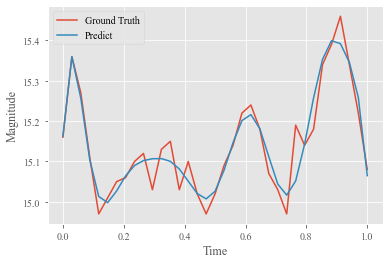

In [11]:
y = np.array(df['Magnitude'])

plt.plot(time, y, label='Ground Truth')
plt.plot(time, np.matmul(A, theta), label='Predict')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig("ls.png", dpi=650)
plt.show()

In [16]:
np.linalg.norm(y - np.matmul(A, theta))

0.23568232810662698

# Solve the Least Square with Tikhonov Regularization

In [12]:
delta = 0.01

tik_solution = np.matmul(np.linalg.inv(np.matmul(A.T, A) + delta * np.identity(13)), np.matmul(A.T, m))

In [27]:
tik_solution

array([ 1.44586602e+01,  2.46507141e+00,  1.17966506e-01, -1.01871526e+00,
       -1.69124559e+00,  1.07629422e-01,  5.15243324e-01, -4.12017744e-02,
        1.60616206e-01, -7.87968802e-02,  8.04452408e-02,  2.31907020e-02,
       -1.06646654e-02])

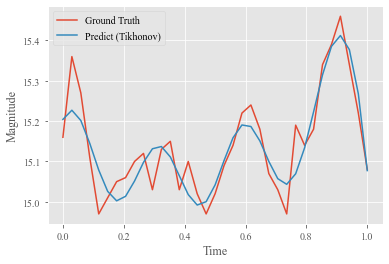

In [14]:
y = np.array(df['Magnitude'])

plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

plot1 = plt.plot(time, y, label='Ground Truth')
plot3 = plt.plot(time, np.matmul(A, tik_solution), label='Predict (Tikhonov)')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig("ls_tik.png", dpi=650)
plt.show()

In [17]:
np.linalg.norm(y - np.matmul(A, tik_solution))

0.31934554405486987

# Solve the Least Square with Total Variation

In [18]:
A.shape

(35, 13)

In [24]:
# Basic Least Square

import numpy as np
from sklearn.linear_model import LinearRegression

X = A
model = LinearRegression(fit_intercept=False).fit(X, y)
model.coef_

array([ 5.43409018e+01,  5.37891141e+01, -1.37531613e+03,  2.56122528e+03,
       -1.23979633e+03, -4.04521431e+00, -3.67728630e+01, -5.56906657e-01,
       -2.00886108e+00, -2.29950223e-01, -2.93117166e-01, -3.95535361e-02,
       -1.03223607e-01])

In [29]:
# Tikhonov Regularization

import numpy as np
from sklearn.linear_model import Lasso

delta = 0.01

X = A
model = Lasso(alpha=delta, fit_intercept=False).fit(X, y)
tv_solution = model.coef_

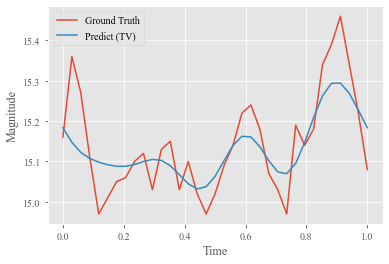

In [30]:
y = np.array(df['Magnitude'])

plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

plot1 = plt.plot(time, y, label='Ground Truth')
plot3 = plt.plot(time, np.matmul(A, tv_solution), label='Predict (TV)')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig("ls_tv.png", dpi=650)
plt.show()

In [31]:
np.linalg.norm(y - np.matmul(A, tv_solution))

0.4553559598894166

# Training Set and Testing Set

In [5]:
A.shape

(35, 13)

In [34]:
train_m = m[:28]
train_time = time[:28]

test_m = m[28:]
test_time = time[27:]

train_A = A[:28]
test_A = A[27:]

## Basic Model

In [24]:
# Basic Least Square

import numpy as np
from sklearn.linear_model import LinearRegression

X = train_A
y = train_m
model = LinearRegression(fit_intercept=False).fit(X, y)
model_solution = model.coef_

In [48]:
np.linalg.norm(np.matmul(train_A, model_solution) - m[:28])

0.15304513975085862

In [49]:
np.linalg.norm(np.matmul(test_A, model_solution) - m[27:])

168.29000383803597

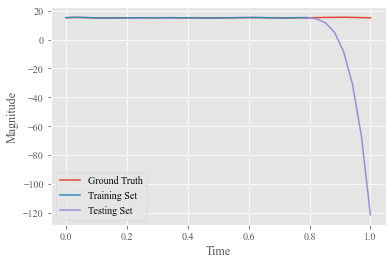

In [46]:
import matplotlib.pyplot as plt

plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

plt.plot(time, m, label='Ground Truth')
plt.plot(train_time, np.matmul(train_A, model_solution), label='Training Set')
plt.plot(test_time, np.matmul(test_A, model_solution), label='Testing Set')

plt.xlabel('Time')
plt.ylabel('Magnitude')

plt.legend()
plt.savefig("train_test_basic.png", dpi=650)
plt.show()

## TV

In [29]:
# Tikhonov Regularization

import numpy as np
from sklearn.linear_model import Lasso

delta = 0.01

X = train_A
y = train_m
model = Lasso(alpha=delta, fit_intercept=False).fit(X, y)
tv_solution = model.coef_

In [55]:
np.linalg.norm(np.matmul(train_A, tv_solution) - m[:28])

0.38903184067398866

In [56]:
np.linalg.norm(np.matmul(test_A, tv_solution) - m[27:])

0.688236069714355

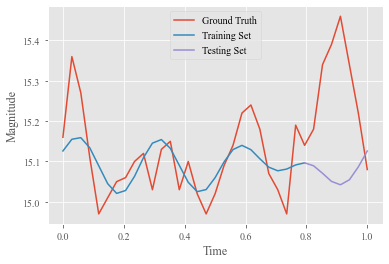

In [44]:
import matplotlib.pyplot as plt

plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

plt.plot(time, m, label='Ground Truth')
plt.plot(train_time, np.matmul(train_A, tv_solution), label='Training Set')
plt.plot(test_time, np.matmul(test_A, tv_solution), label='Testing Set')

plt.xlabel('Time')
plt.ylabel('Magnitude')

plt.legend()
plt.savefig("train_test_tv.png", dpi=650)
plt.show()

## TIK

In [41]:
# Tikhonov Regularization

import numpy as np
from sklearn.linear_model import Ridge

delta = 0.01

X = train_A
y = train_m
model = Ridge(alpha=delta, fit_intercept=False).fit(X, y)
tik_solution = model.coef_

In [50]:
np.linalg.norm(np.matmul(train_A, tik_solution) - m[:28])

0.332573033261299

In [54]:
np.linalg.norm(np.matmul(test_A, tik_solution) - m[27:])

11.667787568471706

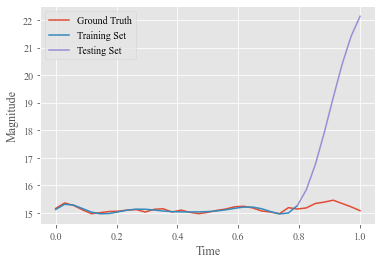

In [45]:
import matplotlib.pyplot as plt

plt.rc("font", family="Times New Roman")
plt.style.use("ggplot")

plt.plot(time, m, label='Ground Truth')
plt.plot(train_time, np.matmul(train_A, tik_solution), label='Training Set')
plt.plot(test_time, np.matmul(test_A, tik_solution), label='Testing Set')

plt.xlabel('Time')
plt.ylabel('Magnitude')

plt.legend()
plt.savefig("train_test_tik.png", dpi=650)
plt.show()